# Corpus and BGRF Composition

We describe and analyse the status quo of the corpus with respect to criteria like author gender, year of first publication, narrative form etc. Then we compare it to the "baseline" of the BGRF.

**TOC**
* [Prerequisites](#Prerequisites)
* [Corpus Metadata](#Corpus-Metadata)
  - [Author Gender](#Author-Gender)
  - [Text Length](#Text-Length)
  - [Year of first publication](#Year-of-first-publication)
* [BGRF Metadata](#BGRF-Metadata)
  - [Configuration](#Configuration)
  - [Data Loading](#Data-Loading)
  

## Prerequisites

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Install with e.g. `pip install sparqlwrapper`
from SPARQLWrapper import SPARQLWrapper, JSON

# Make plots appear directly in the notebook.
%matplotlib inline

The later parts also require access to a Wikibase instance, which is only accessible in/over the university network.

## Corpus Metadata

In [2]:
# Adjust the URL to the .tsv file as needed.
DATA_URL = 'https://raw.githubusercontent.com/MiMoText/roman18/master/XML-TEI/xml-tei_metadata.tsv'
corpus = pd.read_csv(DATA_URL, sep='\t')
print('Available column names:', corpus.columns.values)

Available column names: ['filename' 'au-name' 'title' 'au-gender' 'firsted-yr' 'printSource-yr'
 'form' 'spelling' 'data-capture' 'token count' 'size' 'bgrf']


### Author Gender

Data is in the column 'au-gender'. Possible values are 'F', 'M' and 'U'.

Set of all occuring values: {'F', 'U', 'M'}
% of female authors: 	0.184
% of male authors: 	0.789
% of unknown/other: 	0.026


<AxesSubplot:>

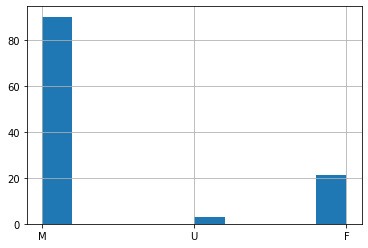

In [3]:
gender = corpus['au-gender']
print('Set of all occuring values:', set(gender.values))
ratio_female = (gender == 'F').sum() / gender.count()
ratio_male = (gender == 'M').sum() / gender.count()
ratio_other = 1 - ratio_female - ratio_male
print(
    f'% of female authors: \t{ratio_female:.3f}\n'
    f'% of male authors: \t{ratio_male:.3f}\n'
    f'% of unknown/other: \t{ratio_other:.3f}'
)
gender.hist()

### Text Length
Data is in the column 'size', possible values are 'short', 'medium', 'long'.

% of short texts: 	0.491
% of medium texts: 	0.289
% of long texts: 	0.219


<AxesSubplot:>

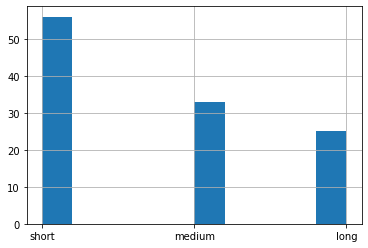

In [4]:
size = corpus['size']
ratio_size_short = (size == 'short').sum() / size.count()
ratio_size_med = (size == 'medium').sum() / size.count()
ratio_size_long = (size == 'long').sum() / size.count()
print(
    f'% of short texts: \t{ratio_size_short:.3f}\n'
    f'% of medium texts: \t{ratio_size_med:.3f}\n'
    f'% of long texts: \t{ratio_size_long:.3f}'
)
size.hist()

### Year of first publication
Data is in the column 'firsted-yr'. However, possible values can be single years `(yyyy)`, year spans `(yyyy-yyyy)`, the floating point number value `NaN`, or even a string like `'unknown'`. Therefore, we need to clean up a bit before we can use it.

<AxesSubplot:>

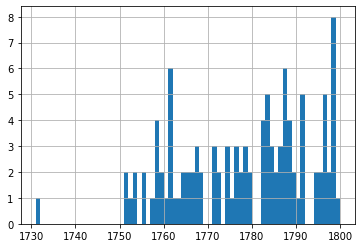

In [5]:
pubyear = (corpus['firsted-yr']
    .astype('|S')
    # In case of year ranges, simply use the first year.
    .replace('(\d{4})-\d{4}', '\1', regex=True))
pubyear = pd.to_numeric(pubyear, errors='coerce').astype('Int64')
time_range = pubyear.max() - pubyear.min()
pubyear.hist(bins=time_range)

### Narrative form
Data is in the column 'form'. Possible values include `'mixed'`, `'autodiegetic'`, `'heterodiegetic'`, `'homodiegetic'`, `'epistolary'`, `'dialogue novel'` and also `NaN`.

Set of all values:  {'mixed', nan, 'heterodiegetic', 'epistolary', 'autodiegetic', 'dialogue novel', 'homodiegetic'}
% of mixed: 	0.036
% of autodiegetic: 	0.250
% of heterodiegetic: 	0.348
% of homodiegetic: 	0.036
% of epistolary: 	0.268
% of dialogue novel: 	0.062


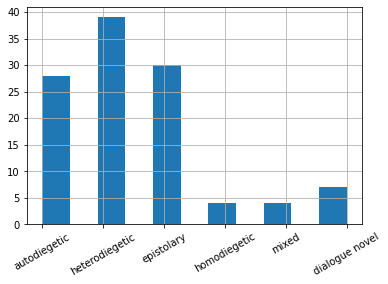

In [6]:
form = corpus['form'].astype('category')
print('Set of all values: ', set(form.values))
print('\n'.join([
    f'% of {kind}: \t{((form==kind).sum()/form.count()):.3f}'
    for kind in [
        'mixed', 'autodiegetic', 'heterodiegetic', 'homodiegetic',
        'epistolary', 'dialogue novel'
    ]
]))
h = form.hist(bins=11)
h.xaxis.set_tick_params(labelrotation=30)

## BGRF Metadata
Data is pulled from Wikibase. For the moment, our instance on port 44100 is used as it contains the most tripels. This may change in the future, which then will not only affect the URL but also the IDs of the items and predicates. Adjust these accordingly in the [Configuration Section](#Configuration).

### Configuration

In [7]:
WB_URL = 'http://zora.uni-trier.de:44100'
ITEM_IDS = {
    'publication_date': 'P7',
    'publication_date_str': 'P43',  # hard to use, since not normalized
    'sex_or_gender': 'P29',    # currently no data on :44100
    'narrative_form': 'P55',   # currently no data on :44100
    'narrative_form_str': 'P47',
    'page_count': 'P35',       # currently no data on :44100
    'page_count_str': 'P45',
}

### Data Loading

We use the SPARQL endpoint to query the bibliography metadata. Each metadatum gets its own query to enhance recall (otherwise some items which have some, but not all, properties set, would get filtered out. This is particularly relevant because there is no data on gender in Wikibase, yet).

In [8]:
bgrf = pd.DataFrame()
wb_endpoint = f'{WB_URL}/proxy/wdqs/bigdata/namespace/wdq/sparql'

def get_data(endpoint, query):
    '''Given an endpoint URL and a SPARQL query, return
    the data as JSON.
    '''
    user_agent = 'jupyter notebook'
    sparql = SPARQLWrapper(endpoint, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()["results"]["bindings"]

Query results are structured like this:
 {'item': {'type': 'uri', 'value': 'http://zora.uni-trier.de:44000/entity/Q28'}, 'pubdate': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '1751-01-01T00:00:00Z'}}
http://zora.uni-trier.de:44000/entity/Q27   1800-01-01
http://zora.uni-trier.de:44000/entity/Q32   1753-01-01
http://zora.uni-trier.de:44000/entity/Q43   1758-01-01
http://zora.uni-trier.de:44000/entity/Q56   1761-01-01
http://zora.uni-trier.de:44000/entity/Q68   1767-01-01
Name: pubyear, dtype: datetime64[ns]


<AxesSubplot:>

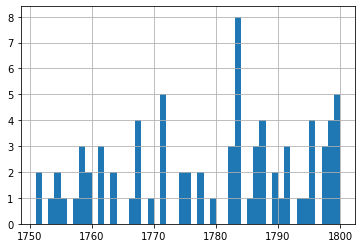

In [49]:
# Publication date
import datetime as dt

query = ''.join([
    'SELECT ?item ?pubdate ',
    'WHERE { ?item wdt:',
    ITEM_IDS['publication_date'],
    ' ?pubdate. }'
])
pubdate = get_data(wb_endpoint, query)

print('Query results are structured like this:\n', pubdate[0])

bgrf['pubyear'] = pd.Series(
    data=[dt.date.fromisoformat(entry['pubdate']['value'].split('T')[0]) for entry in pubdate],
    index=[entry['item']['value'] for entry in pubdate],
    dtype='datetime64[ns]'
)

print(bgrf['pubyear'].head())

year_range = bgrf['pubyear'].max().year - bgrf['pubyear'].min().year
bgrf['pubyear'].hist(bins=year_range)

In [10]:
# Author gender
# NOTE: currently no data in Wikibase at :44100.
query = ''.join([
    'SELECT ?item ?gender ',
    'WHERE { ?item wdt:',
    ITEM_IDS['sex_or_gender'],
    ' ?gender. }'
])
gender = get_data(wb_endpoint, query)

In [47]:
# Page count
# NOTE: I do not know yet how to estimate the text length based
#       on only the page count.
query = ''.join([
    'SELECT ?item ?pages ',
    'WHERE { ?item wdt:',
    ITEM_IDS['page_count_str'],
    ' ?pages. }'
])
page_count = get_data(wb_endpoint, query)

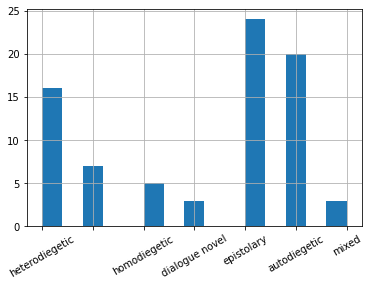

In [62]:
# Narrative form
query = ''.join([
    'SELECT ?item ?form ',
    'WHERE { ?item wdt:',
    ITEM_IDS['narrative_form_str'],
    ' ?form. }'
])
form = get_data(wb_endpoint, query)
form = pd.Series(
    data=[entry['form']['value'] for entry in form],
    index=[entry['item']['value'] for entry in form],
    dtype='category'
)
# This is brutish, but I do not want to write some elaborate
# regexes for something which is essentially still undecided as far
# as the adequate modelling goes.
mapping = {
    'Dialogues': 'dialogue novel',
    'Deux récits 1re personne': '',
    'Ire personne virant à la 3e, avec dialogues': '',
    'Ire personne (mémoires découpés en lettres)': '',
    'Saillard Tchemerzine 3e personne': 'heterodiegetic',
    '3e personne, avec récit intercalé 1re personne': '',
    '1re personne, avec récits intercalés 1re personne': 'autodiegetic',
    '3e personne, avec dialogues, récits intercalés 1re personne, intervention du narrateur': '',
    '3e partie: Relation du voyage d’un sublunaire; 1re personne avec des récits d’autres voyageurs': '',
    '1re personne (mémoires)': 'autodiegetic',
    '1re personne (mémoires), avec récit intercalé 1re personne': 'autodiegetic',
    '1re personne, songe': 'autodiegetic',
    'Lettres, avec récits intercalés 1re personne': 'epistolary',
    'Lettres': 'epistolary',
    'Saint-Fargeau Lettres': 'epistolary',
    '3e personne, avec récits intercalés 1re personne et lettres': 'mixed',
    'Dialogue, avec récits racontés par les personnages': 'dialogue novel',
    '3e personne': 'heterodiegetic',
    '3e personne, avec récit de Jezennemours à la 1re personne': 'homodiegetic',
    '3e personne avec des observations 1re personne': 'homodiegetic',
    'Lettres, interrompues par un récit (I, 83 - 160)': 'mixed',
    '1re personne': 'autodiegetic',
    'Lettres, avec deux histoires intercalées': 'mixed',
    'Cadre 1re personne avec récit 1re personne': 'autodiegetic',
    '3e personne, avec contes intercalés 3e personne (I, 43, Le plaisir, conte moral; II, 10, Aventure du pèlerin)': 'homodiegetic',
    '3e personne, interrompu par des conversations': 'homodiegetic',
    'Ire personne': 'autodiegetic',
    '3e personne, avec récits intercalés 1re personne': 'homodiegetic',
}
#print('\n'.join([i for i in set(bgrf['form'].values) ]))
bgrf['form'] = form.replace(mapping)
bgrf['form'].head()
h = bgrf['form'].hist(bins=15)
h.xaxis.set_tick_params(labelrotation=30)